<a href="https://colab.research.google.com/github/pachterlab/GVFP_2021/blob/dev/gg220626_bf_basics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Figure 4

## Functions

In [1]:
# Scientific computing imports
import numpy as np
from numpy.fft import irfftn
from numpy.random import choice
from scipy.stats import rv_discrete, poisson, nbinom, gaussian_kde
import matplotlib.pyplot as plt


# Plotting
import matplotlib.pyplot as plt
import matplotlib as mpl

# Utility function that converts between (x, y) qualitative regime coordinates to original parameters.
def convert_xy_to_params(x, y, beta, gamma, K_avg):
    kappa = (beta + gamma)*(x/(1-x))
    a_over_th = 1/y - 1
    theta = np.sqrt(kappa*K_avg/a_over_th)
    a = K_avg*kappa/theta
    return a, kappa, theta


# Sample from flattened 2D probability distribution p. 
# mx = [mx0, mx1] is the shape of the 2D domain we're sampling.
def sample_from_p(mx, num_data_points, p_flat):
    x_N, x_M = np.arange(mx[0]), np.arange(mx[1])
    X_N, X_M = np.meshgrid(x_N, x_M, indexing='ij')    # get grid of possible values
    x_choices = np.arange(np.prod(mx))                 # represent each grid point as a point in a 1D vector
    
    samples = choice(x_choices, size=num_data_points, replace=True, p=p_flat)
    d_N, d_M = X_N.flatten()[samples], X_M.flatten()[samples]    
    return d_N, d_M


# Get maximum of a 2D array
def get_2D_max(array):
    return np.unravel_index(array.argmax(), array.shape)


# Get KDE for smooth-looking heatmaps.
def get_2D_KDE(x_stats, y_stats, x_min=0, x_max=1, y_min=0, y_max=1):
    num_pts = 100                          # hyperparameter
    x_arg = np.linspace(x_min, x_max, num_pts)
    y_arg = np.linspace(y_min, y_max, num_pts)

    X_arg, Y_arg = np.meshgrid(x_arg, y_arg, indexing='ij')      # grid of points      X0, X1

 
    positions = np.vstack([X_arg.ravel(), Y_arg.ravel()])
    kernel = gaussian_kde([x_stats, y_stats])
    KDE = np.reshape(kernel(positions).T, X_arg.shape)
    return KDE, x_arg, y_arg
    
# Constitutive model likelihood function.
def get_Poiss_2sp(mx, params):
    beta, gamma, a, kappa, theta = params 
    K_avg = (a*theta)/kappa
    mu_N, mu_M = K_avg/beta, K_avg/gamma
    
    x_N, x_M = np.arange(mx[0]), np.arange(mx[1])
    X_N, X_M = np.meshgrid(x_N, x_M, indexing='ij')
    
    return poisson.pmf(X_N, mu_N)*poisson.pmf(X_M, mu_M)


# Mixture model likelihood function.
def get_NB_2sp(mx, params):
    beta, gamma, a, kappa, theta = params 
    
    # Get generating function argument
    u = []
    half = mx[:]
    half[-1] = mx[-1]//2 + 1
    for i in range(len(mx)):
        l = np.arange(half[i])
        u_ = np.exp(-2j*np.pi*l/mx[i])-1
        u.append(u_)
    g = np.meshgrid(*[u_ for u_ in u], indexing='ij')
    for i in range(len(mx)):
        g[i] = g[i].flatten()
    
    # Get generating function
    gf = np.exp(- (a/kappa)*np.log(1 - theta*(g[0]/beta + g[1]/gamma)))
    gf = gf.reshape(tuple(half))
                              
    Pss = irfftn(gf, s=mx)                        # Get Pss by inverse fast Fourier transform
    Pss = np.abs(Pss)/np.sum(np.abs(Pss))           # Normalize
    return Pss


def ll_NB(phi, const, mx, data):
    # Get parameters
    x, y = phi
    beta, gamma, K_avg = const
    
    # Convert from (x, y) to original parameters
    a, kappa, theta = convert_xy_to_params(x, y, beta, gamma, K_avg)
    params = [beta, gamma, a, kappa, theta]
    
    Pss = get_NB_2sp(mx, params)    # Compute Pss

    lp = np.log(Pss)
    result = np.sum(lp[data])
    return result
  
  # Get 2 species GOU generating function using ODE method
def get_gf_GOU_2sp_ODE(g0, g1, params):
    beta_0, beta_1, a, kappa, theta = params     # get parameters
    
    c0 = (g0) + (beta_0/(beta_1 - beta_0))*(g1)       #  relevant linear combinations of g_i
    c1 = - (beta_0/(beta_1 - beta_0))*(g1)   
    
    min_fudge, max_fudge = 1, 10                                     # Determine integration time scale / length
    dt = np.min([1/kappa, 1/theta, 1/beta_0, 1/beta_1])*min_fudge
    t_max = np.max([1/kappa, 1/theta, 1/beta_0, 1/beta_1])*max_fudge
    num_tsteps = int(np.ceil(t_max/dt))
    
    t_array = np.linspace(0, t_max, num_tsteps+1)
    t_array = t_array.reshape((1, num_tsteps + 1))
    
    q = np.zeros((g0.shape[0], num_tsteps + 1), dtype=np.complex64)    # initialize array to store ODE
    c0 = c0.reshape((c0.shape[0],1))
    c1 = c1.reshape((c1.shape[0],1))
    q0 = theta*c0*(np.exp(-beta_0*t_array) - np.exp(-kappa*t_array))/(kappa - beta_0) 
    q1 = theta*c1*(np.exp(-beta_1*t_array) - np.exp(-kappa*t_array))/(kappa - beta_1)
    q = q0 + q1
    

    integrand = q/(1-q)
    integral = np.trapz(integrand, dx=dt, axis=1)     # integrate ODE solution
    gf = np.exp( a*integral)               # get generating function
    return gf


# Get Pss for 2 species GOU model via ODE method
def get_GOU_2sp(mx, params):
    # Get generating function argument
    u = []
    half = mx[:]
    half[-1] = mx[-1]//2 + 1
    for i in range(len(mx)):
        l = np.arange(half[i])
        u_ = np.exp(-2j*np.pi*l/mx[i])-1
        u.append(u_)
    g = np.meshgrid(*[u_ for u_ in u], indexing='ij')
    for i in range(len(mx)):
        g[i] = g[i].flatten()
    
    # Get generating function
    gf = get_gf_GOU_2sp_ODE(g[0], g[1], params)                    
    gf = gf.reshape(tuple(half))
    
    Pss = irfftn(gf, s=mx)                        # Get Pss by inverse fast Fourier transform
    Pss = np.abs(Pss)/np.sum(np.abs(Pss))           # Normalize
    return Pss


# Log likelihood of GOU model given data. Uses (x,y) as input instead of (kappa, theta).
def ll_GOU(phi, const, mx, data):
    # Get parameters
    x, y = phi
    beta, gamma, K_avg = const
    
    # Convert from (x, y) to original parameters
    a, kappa, theta = convert_xy_to_params(x, y, beta, gamma, K_avg)
    params = [beta, gamma, a, kappa, theta]
    
    Pss = get_GOU_2sp(mx, params)    # Compute Pss

    lp = np.log(Pss)
    result = np.sum(lp[data])
    return result


# Combines the above functions into one to reduce overhead associated with Python function calls.
# Helpful when doing expensive posterior sampling (since many likelihood function calls are required).
def ll_GOU2(phi, const, mx, data):
    # Get parameters
    x, y = phi
    beta, gamma, K_avg = const
    
    
    # Convert from (x, y) to original parameters
    a, kappa, theta = convert_xy_to_params(x, y, beta, gamma, K_avg)
    params = [beta, gamma, a, kappa, theta]
    
    
    # Get generating function argument
    u = []
    half = mx[:]
    half[-1] = mx[-1]//2 + 1
    for i in range(len(mx)):
        l = np.arange(half[i])
        u_ = np.exp(-2j*np.pi*l/mx[i])-1
        u.append(u_)
    g = np.meshgrid(*[u_ for u_ in u], indexing='ij')
    for i in range(len(mx)):
        g[i] = g[i].flatten()
    
    # Get generating function
    beta_0 = beta
    beta_1 = gamma
    
    c0 = (g[0]) + (beta_0/(beta_1 - beta_0))*(g[1])       #  relevant linear combinations of g_i
    c1 = - (beta_0/(beta_1 - beta_0))*(g[1])   
    
    min_fudge, max_fudge = 0.5, 10                                     # Determine integration time scale / length
    dt = np.min([1/kappa, 1/theta, 1/beta_0, 1/beta_1])*min_fudge
    t_max = np.max([1/kappa, 1/theta, 1/beta_0, 1/beta_1])*max_fudge
    num_tsteps = int(np.ceil(t_max/dt))
    
    t_array = np.linspace(0, t_max, num_tsteps+1)
    t_array = t_array.reshape((1, num_tsteps + 1))
    
    q = np.zeros((c0.shape[0], num_tsteps + 1), dtype=np.complex64)    # initialize array to store ODE
    c0 = c0.reshape((c0.shape[0],1))
    c1 = c1.reshape((c1.shape[0],1))
    q0 = theta*c0*(np.exp(-beta_0*t_array) - np.exp(-kappa*t_array))/(kappa - beta_0) 
    q1 = theta*c1*(np.exp(-beta_1*t_array) - np.exp(-kappa*t_array))/(kappa - beta_1)
    q = q0 + q1

    integrand = q/(1-q)
    integral = np.trapz(integrand, dx=dt, axis=1)     # integrate ODE solution
    gf = np.exp( a*integral)               # get generating function
    
    gf = gf.reshape(tuple(half))
    
    Pss = irfftn(gf, s=mx)                        # Get Pss by inverse fast Fourier transform
    Pss = np.abs(Pss)/np.sum(np.abs(Pss))           # Normalize

    lp = np.log(Pss)
    result = np.sum(lp[data])
    return result
  
  # ODE for 2 species CIR model
def f_2sp(q, t, c0, c1, params):
    beta_0, beta_1, a, kappa, theta = params
    result = - kappa*q + theta*q*q + kappa*( c0*np.exp(-beta_0*t) + c1*np.exp(-beta_1*t)  ) 
    return result


# Vectorized RK4 implementation for 2 species CIR model
def RK4_2sp(q, f, t, c0, c1, step_size, param):
    j1 = f(q, t, c0, c1, param)
    j2 = f(q + (step_size/2)*j1, t + (step_size/2), c0, c1, param)   
    j3 = f(q + (step_size/2)*j2, t + (step_size/2), c0, c1, param)   
    j4 = f(q + (step_size)*j3, t + (step_size), c0, c1, param)  
    
    q_new = q + (step_size/6)*(j1 + 2*j2 + 2*j3 + j4)
    return q_new


# Get 2 species CIR generating function using ODE method
def get_gf_CIR_2sp(g0, g1, params):
    beta_0, beta_1, a, kappa, theta = params     # get parameters
    
    c0 = (g0) + (beta_0/(beta_1 - beta_0))*(g1)       #  relevant linear combinations of g_i
    c1 = - (beta_0/(beta_1 - beta_0))*(g1)   
    
    min_fudge, max_fudge = 0.5, 10                                     # Determine integration time scale / length
    dt = np.min([1/kappa, 1/theta, 1/beta_0, 1/beta_1])*min_fudge
    t_max = np.max([1/kappa, 1/theta, 1/beta_0, 1/beta_1])*max_fudge
    num_tsteps = int(np.ceil(t_max/dt))
     
    q = np.zeros((g0.shape[0], num_tsteps + 1), dtype=np.complex64)    # initialize array to store ODE
    
    # Solve ODE using RK4 method 
    for i in range(0, num_tsteps):
        t = i*dt
        q[:,i+1] = RK4_2sp(q[:,i], f_2sp, t, c0, c1, dt, params)
        
    integral = np.trapz(q, dx=dt, axis=1)     # integrate ODE solution
    gf = np.exp((a*theta/kappa)*integral)               # get generating function
    return gf


# Get Pss for 2 species CIR model via ODE method
def get_CIR_2sp(mx, params):
    # Get generating function argument
    u = []
    half = mx[:]
    half[-1] = mx[-1]//2 + 1
    for i in range(len(mx)):
        l = np.arange(half[i])
        u_ = np.exp(-2j*np.pi*l/mx[i])-1
        u.append(u_)
    g = np.meshgrid(*[u_ for u_ in u], indexing='ij')
    for i in range(len(mx)):
        g[i] = g[i].flatten()
    
    # Get generating function
    gf = get_gf_CIR_2sp(g[0], g[1], params)                    
    gf = gf.reshape(tuple(half))
                              
    Pss = irfftn(gf, s=mx)                        # Get Pss by inverse fast Fourier transform
    Pss = np.abs(Pss)/np.sum(np.abs(Pss))           # Normalize
    return Pss


# Log likelihood of CIR model given data. Uses (x,y) as input instead of (kappa, theta).
def ll_CIR(phi, const, mx, data):
    # Get parameters
    x, y = phi
    beta, gamma, K_avg = const
    
    # Convert from (x, y) to original parameters
    a, kappa, theta = convert_xy_to_params(x, y, beta, gamma, K_avg)
    params = [beta, gamma, a, kappa, theta]
    
    Pss = get_CIR_2sp(mx, params)    # Compute Pss

    lp = np.log(Pss)
    result = np.sum(lp[data])
    return result
  
  # Generates synthetic data (either CIR or GOU) and computes log Bayes factor (e.g. P(CIR)/P(GOU))).
# Does this averaged over many trials (num_trials).
# Does this assuming different numbers of data points (e.g. num_data_points = [100, 200, 1000]). 
def log_bayes_factor_avg(model, num_data_points, num_trials, mx, params):
    
    # Initialize log BF arrays 
    num_kinds = len(num_data_points) 
    log_bf_joint = np.zeros((num_kinds, num_trials))
    log_bf_nascent = np.zeros((num_kinds, num_trials))
    log_bf_mature = np.zeros((num_kinds, num_trials))
    
    
    # Get Pss for each model given this parameter set
    if model=='CIR':
        pss = get_CIR_2sp(mx, params)
        pss_other = get_GOU_2sp(mx, params)
    elif model=='GOU':
        pss = get_GOU_2sp(mx, params)
        pss_other = get_CIR_2sp(mx, params)
    p_flat = pss.flatten()
    
    
    # Get fake data
    for r in range(0, num_kinds):
        for t in range(0, num_trials):
            
            # Sample nascent and mature counts
            d_N, d_M = sample_from_p(mx, num_data_points[r], p_flat)

            # Log-likelihood functions
            lp = np.log10(pss)    # shape: x_N_domain by x_M_domain
            lp_nascent = np.log10(np.sum(pss, axis=1))
            lp_mature = np.log10(np.sum(pss, axis=0))

            lp_other = np.log10(pss_other)
            lp_other_nascent = np.log10(np.sum(pss_other, axis=1))
            lp_other_mature = np.log10(np.sum(pss_other, axis=0))

            # Log-likelihoods given data
            ll_joint = np.sum(lp[d_N, d_M])
            ll_nascent = np.sum(lp_nascent[d_N])
            ll_mature = np.sum(lp_mature[d_M])

            ll_other_joint = np.sum(lp_other[d_N, d_M])
            ll_other_nascent = np.sum(lp_other_nascent[d_N]) 
            ll_other_mature = np.sum(lp_other_mature[d_M])

            # Bayes factor
            log_bf_joint[r,t] = ll_joint - ll_other_joint
            log_bf_nascent[r,t] = ll_nascent - ll_other_nascent
            log_bf_mature[r,t] = ll_mature - ll_other_mature
                          
        log_bf_joint_avg = np.mean(log_bf_joint, axis=1)
        log_bf_nascent_avg = np.mean(log_bf_nascent, axis=1)
        log_bf_mature_avg = np.mean(log_bf_mature, axis=1)
    
    return log_bf_joint_avg, log_bf_nascent_avg, log_bf_mature_avg
 # Compute averaged log Bayes factors for GOU vs Poisson, GOU vs NB, CIR vs Poisson, and CIR vs NB.
def log_bayes_factor_avg_null(num_data_points, num_trials, mx, params):
    
    # Get Pss for each model given this parameter set
    pss_CIR = get_CIR_2sp(mx, params)
    pss_GOU = get_GOU_2sp(mx, params)
    pss_Poiss = get_Poiss_2sp(mx, params)
    pss_NB = get_NB_2sp(mx, params)
    
    # Initialize log BF arrays
    log_bf_CIR_vs_Poiss, log_bf_CIR_vs_NB = np.zeros(num_trials), np.zeros(num_trials)
    log_bf_GOU_vs_Poiss, log_bf_GOU_vs_NB = np.zeros(num_trials), np.zeros(num_trials)
    
    for t in range(0, num_trials):
        
        # Get fake data
        d_GOU_N, d_GOU_M = sample_from_p(mx, num_data_points, pss_GOU.flatten())
        d_CIR_N, d_CIR_M = sample_from_p(mx, num_data_points, pss_CIR.flatten())


        # Log-likelihood functions
        lp_CIR = np.log10(pss_CIR)    # shape: mx[0] by mx[1]
        lp_GOU = np.log10(pss_GOU)  
        lp_Poiss = np.log10(pss_Poiss) 
        lp_NB = np.log10(pss_NB) 


        # Log-likelihoods given data
        log_bf_CIR_vs_Poiss[t] = np.sum(lp_CIR[d_CIR_N, d_CIR_M]) - np.sum(lp_Poiss[d_CIR_N, d_CIR_M]) 
        log_bf_CIR_vs_NB[t] = np.sum(lp_CIR[d_CIR_N, d_CIR_M]) - np.sum(lp_NB[d_CIR_N, d_CIR_M]) 

        log_bf_GOU_vs_Poiss[t] = np.sum(lp_GOU[d_GOU_N, d_GOU_M]) - np.sum(lp_Poiss[d_GOU_N, d_GOU_M]) 
        log_bf_GOU_vs_NB[t] = np.sum(lp_GOU[d_GOU_N, d_GOU_M]) - np.sum(lp_NB[d_GOU_N, d_GOU_M]) 
        
    log_bf_CIR_vs_Poiss_avg = np.mean(log_bf_CIR_vs_Poiss)
    log_bf_CIR_vs_NB_avg = np.mean(log_bf_CIR_vs_NB)
    log_bf_GOU_vs_Poiss_avg = np.mean(log_bf_GOU_vs_Poiss)
    log_bf_GOU_vs_NB_avg = np.mean(log_bf_GOU_vs_NB)

    
    return log_bf_CIR_vs_Poiss_avg, log_bf_CIR_vs_NB_avg, log_bf_GOU_vs_Poiss_avg, log_bf_GOU_vs_NB_avg
  

  
 # This function analyzes and plots the posterior samples.
def analyze_posteriors(string_ID, x_stats, y_stats, params_true, loc=True, k_max=0, th_max=0):
    
    # True parameters
    beta, gamma, a_true, kappa_true, theta_true = params_true
    x_true, y_true = (kappa_true)/(kappa_true + beta + gamma), (theta_true)/(theta_true + a_true)
   

    # Get statistics in terms of kappa and theta
    a_stats, kappa_stats, theta_stats = convert_xy_to_params(x_stats, y_stats, beta, gamma, K_avg)

    
    # KDEs
    KDE_xy, x_arg, y_arg = get_2D_KDE(x_stats, y_stats, 0, 1, 0, 1)
    if k_max==0:
        k_max = np.max(kappa_stats)
    if th_max==0:
        th_max = np.max(theta_stats)
    KDE_kth, k_arg, th_arg = get_2D_KDE(kappa_stats, theta_stats, 0, k_max, 0, th_max)
    
    KDE_x = np.sum(KDE_xy, axis=1)
    KDE_x = KDE_x/np.trapz(KDE_x, x=x_arg)
    KDE_y = np.sum(KDE_xy, axis=0)
    KDE_y = KDE_y/np.trapz(KDE_y, x=y_arg)
    
    KDE_k = np.sum(KDE_kth, axis=1)
    KDE_k = KDE_k/np.trapz(KDE_k, x=k_arg)
    KDE_th = np.sum(KDE_kth, axis=0)
    KDE_th = KDE_th/np.trapz(KDE_th, x=th_arg)
    
    # Summary statistics
    x_avg, y_avg = np.mean(x_stats), np.mean(y_stats)    # posterior means
    i, j = get_2D_max(KDE_xy)
    x_map, y_map = x_arg[i], y_arg[j]
    
    k_avg, th_avg = np.mean(kappa_stats), np.mean(theta_stats)    # posterior means
    i, j = get_2D_max(KDE_kth)
    k_map, th_map = k_arg[i], th_arg[j]
    
    
    
    
    print("Plotting histograms in terms of (x,y)...")
    vals, _,  _ = plt.hist(x_stats, alpha=0.5, density=True)
    plt.plot(x_true*np.ones(10), np.linspace(0, np.max(vals), 10), linestyle='--', color='black', linewidth=2, label='true')
    plt.plot(x_avg*np.ones(10), np.linspace(0, np.max(vals), 10), linestyle='--', color='red', linewidth=2, label='avg')
    plt.plot(x_map*np.ones(10), np.linspace(0, np.max(vals), 10), linestyle='--', color='blue', linewidth=2, label='MAP')
    plt.plot(x_arg, KDE_x, color='black')
    plt.xlabel('$\\kappa/(\\kappa + \\beta + \\gamma)$', fontsize=30)
    plt.ylabel('Probability', fontsize=30)
    plt.legend(fontsize=20)
    plt.savefig("results/post_marg_x_"+string_ID+".png", bbox_inches='tight')
    plt.savefig("results/post_marg_x_"+string_ID+".pdf", bbox_inches='tight')
    plt.show()

    vals, _, _ = plt.hist(y_stats, alpha=0.5, density=True)
    plt.plot(y_true*np.ones(10), np.linspace(0, np.max(vals), 10), linestyle='--', color='black', linewidth=2, label='true')
    plt.plot(y_avg*np.ones(10), np.linspace(0, np.max(vals), 10), linestyle='--', color='red', linewidth=2, label='avg')
    plt.plot(y_map*np.ones(10), np.linspace(0, np.max(vals), 10), linestyle='--', color='blue', linewidth=2, label='MAP')
    plt.plot(y_arg, KDE_y, color='black')
    plt.xlabel('$\\theta/(\\theta + a)$', fontsize=30)
    plt.ylabel('Probability', fontsize=30)
    plt.legend(fontsize=20)
    plt.savefig("results/post_marg_y_"+string_ID+".png", bbox_inches='tight')
    plt.savefig("results/post_marg_y_"+string_ID+".pdf", bbox_inches='tight')
    plt.show()
    
    
    print("Plotting histograms in terms of (kappa, theta)...")
    vals, _,  _ = plt.hist(kappa_stats, alpha=0.5, density=True)
    plt.plot(kappa_true*np.ones(10), np.linspace(0, np.max(vals), 10), linestyle='--', color='black', linewidth=2, label='true')
    plt.plot(k_avg*np.ones(10), np.linspace(0, np.max(vals), 10), linestyle='--', color='red', linewidth=2, label='avg')
    plt.plot(k_map*np.ones(10), np.linspace(0, np.max(vals), 10), linestyle='--', color='blue', linewidth=2, label='MAP')
    plt.plot(k_arg, KDE_k, color='black')
    plt.xlabel('$\\kappa$', fontsize=30)
    plt.ylabel('Probability', fontsize=30)
    plt.legend(fontsize=20)
    plt.savefig("results/post_marg_kappa_"+string_ID+".png", bbox_inches='tight')
    plt.savefig("results/post_marg_kappa_"+string_ID+".pdf", bbox_inches='tight')
    plt.show()

    vals, _, _ = plt.hist(theta_stats, alpha=0.5, density=True)
    plt.plot(theta_true*np.ones(10), np.linspace(0, np.max(vals), 10), linestyle='--', color='black', linewidth=2, label='true')
    plt.plot(th_avg*np.ones(10), np.linspace(0, np.max(vals), 10), linestyle='--', color='red', linewidth=2, label='avg')
    plt.plot(th_map*np.ones(10), np.linspace(0, np.max(vals), 10), linestyle='--', color='blue', linewidth=2, label='MAP')
    plt.plot(th_arg, KDE_th, color='black')
    plt.xlabel('$\\theta$', fontsize=30)
    plt.ylabel('Probability', fontsize=30)
    plt.legend(fontsize=20)
    plt.savefig("results/post_marg_theta_"+string_ID+".png", bbox_inches='tight')
    plt.savefig("results/post_marg_theta_"+string_ID+".pdf", bbox_inches='tight')
    plt.show()
    
    s= mpl.rcParams['lines.markersize']**2
    newsize=3*s
    
    print("Plotting 2D heatmap in terms of (x, y)...")
    
    fig = plt.figure(figsize=(4,4))
    ax = fig.add_subplot(111)

    ax.scatter(x_map, y_map, color='blue', label='MAP', s=newsize, edgecolor='white')
    ax.scatter(x_avg, y_avg, color='red', label='avg', s=newsize, edgecolor='white')
    ax.scatter(x_true, y_true, color='black', label='true', s=newsize, edgecolor='white')
    ax.imshow(np.transpose(KDE_xy), origin='lower', extent=[0, 1, 0, 1])

    if loc==True:
        plt.legend(fontsize=18, framealpha=1)
    plt.savefig('results/post_2D_xy_'+string_ID+'.pdf', bbox_inches='tight')
    plt.savefig('results/post_2D_xy_'+string_ID+'.png', bbox_inches='tight')

    plt.show()
    
    
    
    
        
    print("Plotting 2D heatmap in terms of (kappa, theta)...")
    w1 = 60
    w2 = 60
    
    fig = plt.figure(figsize=(4,4))
    ax = fig.add_subplot(111)

    ax.scatter(k_map, th_map, color='blue', label='MAP', s=newsize, edgecolor='white')
    ax.scatter(k_avg, th_avg, color='red', label='avg', s=newsize, edgecolor='white')
    ax.scatter(kappa_true, theta_true, color='black', label='true', s=newsize, edgecolor='white')
    ax.imshow( np.transpose(KDE_kth[:w1,:w2]), origin='lower', extent=[0, k_arg[w1], 0, th_arg[w2]], aspect='auto')

    plt.savefig('results/post_2D_kth_'+string_ID+'.pdf', bbox_inches='tight')
    plt.savefig('results/post_2D_kth_'+string_ID+'.png', bbox_inches='tight')

    plt.show()

    
    
    return


In [2]:
def get_log_likelihood_NB(data, string_ID, num_x = 50, num_y = 50):
    d_N, d_M = data
    K_avg = 1
    beta = K_avg/d_N.mean()
    gamma = K_avg/d_M.mean()
    mx = [np.max(d_N)+10,np.max(d_M)+10]
    const = beta, gamma, K_avg

    # Parameter bounds
    epsilon = 0.005
    x_min, x_max = epsilon, 1-epsilon
    y_min, y_max = epsilon, 1-epsilon
    x, y = np.linspace(x_min, x_max, num_x), np.linspace(y_min, y_max, num_y)

    logL_NB = np.zeros((num_x, num_y))

    params = [beta, gamma, 1, 1, 1]

    Input = []
    for i in range(0, num_x):
        for j in range(0, num_y):
            phi = [x[i], y[j]]
            logL_NB[i,j]=ll_NB(phi, const, mx, data)

    e=np.max(logL_NB)
    
    llh_NB = np.exp(logL_NB-e)
   
    np.savetxt("./loom/grid_results/gg220626_res/logL_"+string_ID+"_NB.txt",logL_NB)

    return

## Global

In [150]:
samples = ['allen_C01_glu','allen_B08_glu','allen_H12_glu','allen_F08_glu']

# sample = 'allen_C01_glu'
sample=samples[0]
gn_cir = ['App','Grin2b','Scai','Cox6b1', 'Mdh1', 'Ndfip1', 'Ndfip2', 'Pitpnc1','Stmn3']
gn_gou = [ 'Atxn1', 'Cdh12', 'Edil3', 'Igf1r', 'Kcnk2', 'Plxna4', 'Satb1',  'Sez6l', 'Slc35f1','Slc24a3']
gn_ext = ['Cyfip2', 'Gnaq', 'Gsk3b', 'Kifap3', 'Mycbp2', 'Prrc2c', 'Unc80','Adcy2','Mbnl2','Meg3']
# gn_ext = np.array(['Cyfip2', 'Gnaq', 'Gsk3b', 'Kifap3', 'Mycbp2',
#        'Prrc2c', 'Unc80','Meg3','Mbnl2'], dtype='<U16')
# gn_gou = np.array([ 'Atxn1', 'Cdh12', 'Edil3', 'Igf1r', 'Kcnk2', 
#                    'Plxna4', 'Satb1',  'Sez6l', 'Slc35f1','Slc24a3'],
#       dtype='<U16')
# gn_cir = np.array(['Cox6b1','Adcy2','Scai', 'Mdh1', 'Ndfip1', 'Ndfip2', 'Pitpnc1',
#        'Stmn3'], dtype='<U16')

           
# g_ext = ['App', 'Cyfip2', 'Gnaq', 'Grin2b', 'Gsk3b', 'Kifap3', 'Mycbp2',
#        'Prrc2c', 'Unc80']
# g_gou = ['Adcy2', 'Atxn1', 'Cdh12', 'Edil3', 'Igf1r', 'Kcnk2', 'Mbnl2',
#        'Meg3', 'Plxna4', 'Satb1', 'Scai', 'Sez6l', 'Slc35f1']
# g_cir = ['Cox6b1', 'Mdh1', 'Ndfip1', 'Ndfip2', 'Pitpnc1', 'Slc24a3',
#        'Stmn3']
genes =  g_ext + g_gou + g_cir

In [68]:
len(genes)

29

In [34]:
!pwd
datadir='loom/'
resultdir="./loom/grid_results/gg220626_res/"

/home/ggorin/projects/GVFP_2021


## Posterior 

In [35]:
def plot_posteriors_grid(gene, model, ax):
    model_ID = gene+"_"+model
    logL=np.loadtxt(resultdir+"logL_"+sample+"_"+gene+"_"+model+".txt")
    c=np.max(logL)
#     print(logL)
    llh = np.power(10,logL-c)
#     EPS = 1e-
#     print(llh.shape)
    llh_min = llh[llh>0].min()
    llh[llh<llh_min] = llh_min
    
    ax.imshow(np.log(np.transpose(llh)), extent=(0,1,0,1), origin='lower');
    ax.set_title(gene)
    ax.set_xticks([])
    ax.set_yticks([])
    return c

In [36]:
genes[-1]

'Stmn3'

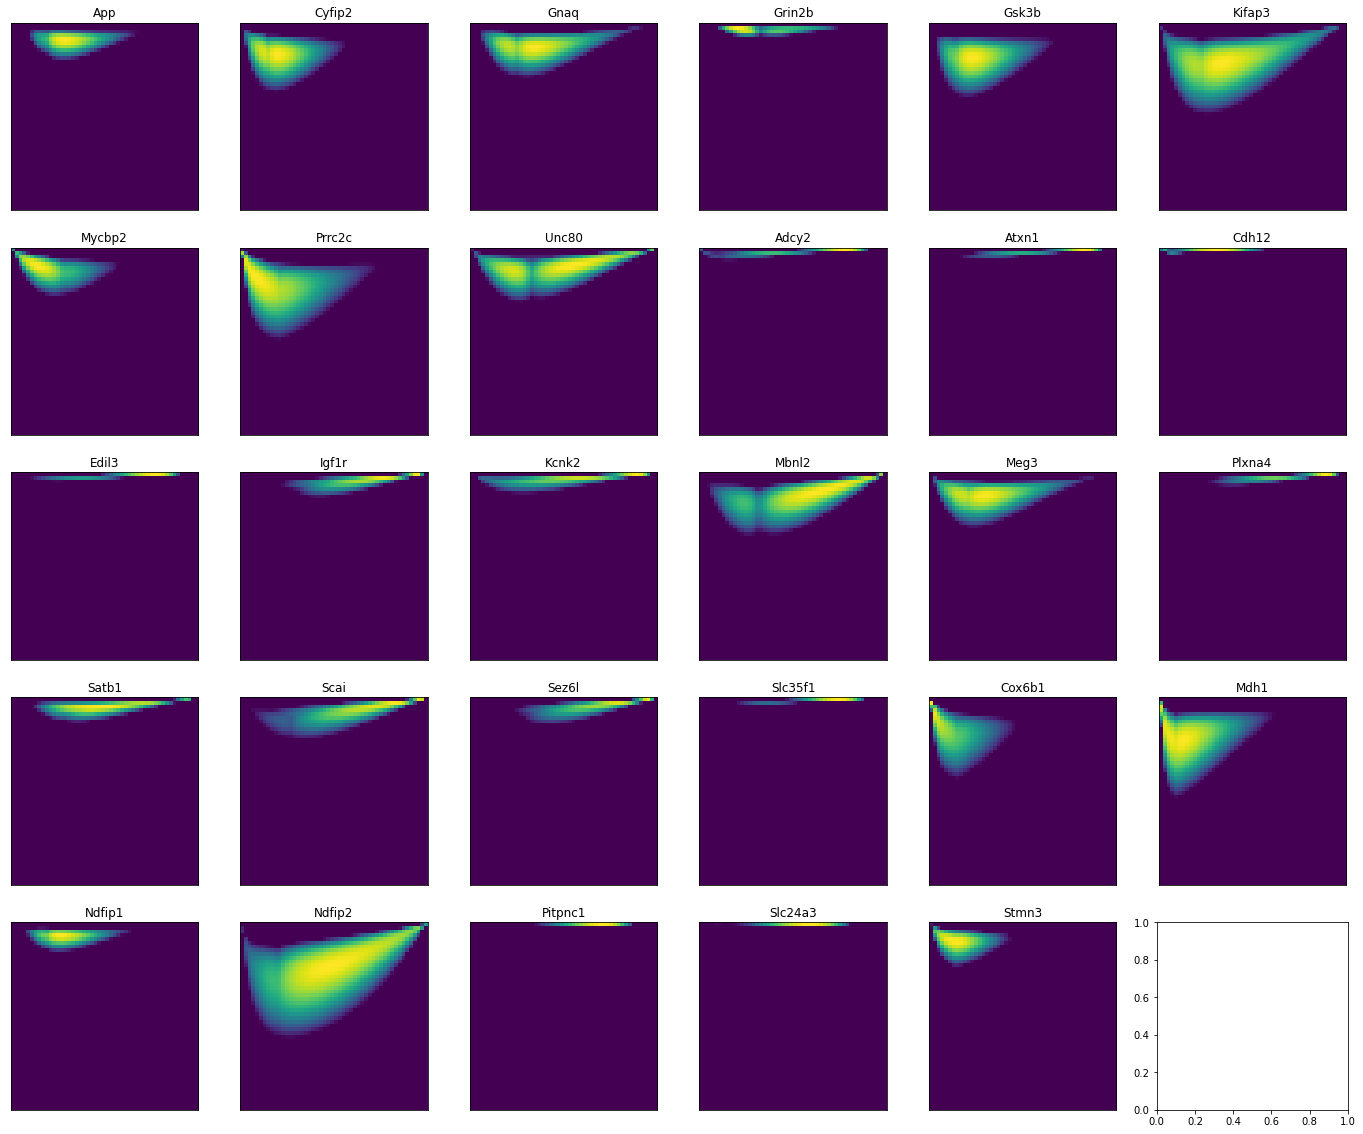

In [37]:
fig, axs = plt.subplots(5,6,figsize=(24,20))
for i,gene in enumerate(genes):
    gou_ml = plot_posteriors_grid(gene, "GOU", axs[i//6,i%6])

In [38]:
gou_ml

-25862.80466549832

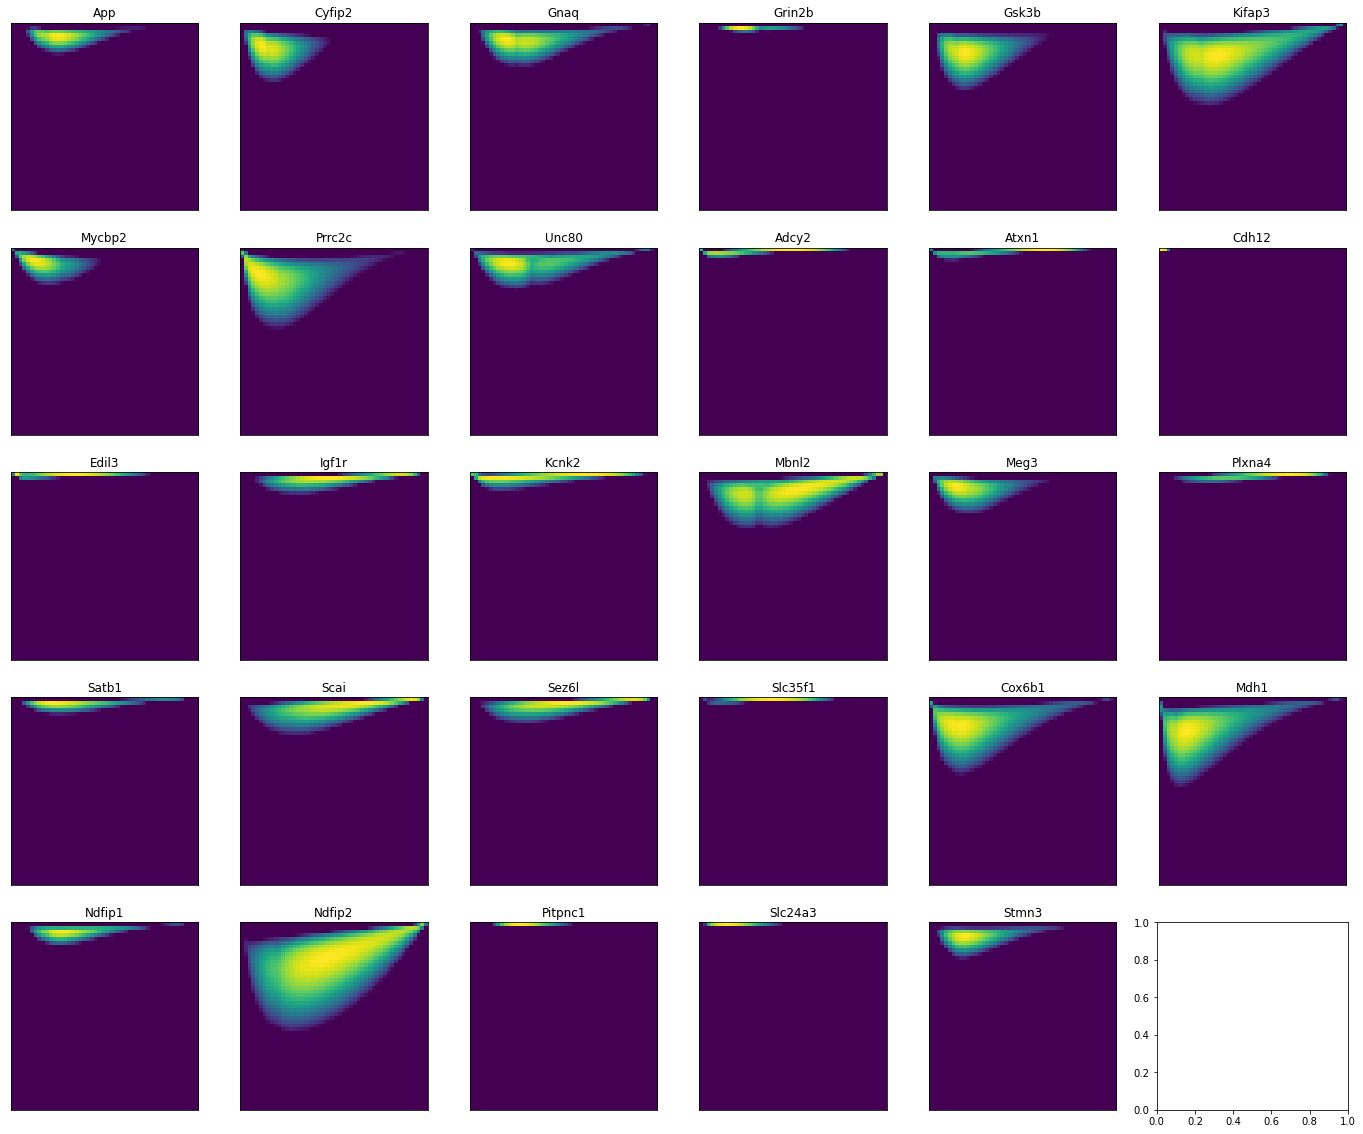

In [39]:
fig, axs = plt.subplots(5,6,figsize=(24,20))
for i,gene in enumerate(genes):
    cir_ml = plot_posteriors_grid(gene, "CIR", axs[i//6,i%6])

In [40]:
cir_ml-gou_ml

434.0098460895024

## Histograms

### Generate NB results

In [46]:
import loompy as lp

with lp.connect(datadir+sample+'.loom') as ds:
    S = ds.layers['spliced'][:]
    U = ds.layers['unspliced'][:]
    gene_names = ds.ra['gene_name']
    nCells = len(ds.ca['barcode'])
    for gene in genes:
        gene_ID = sample+"_"+gene 
        i = np.where(gene_names==gene)[0][0]
        d_M = S[i].astype(int)
        d_N = U[i].astype(int)
        data = [d_N, d_M]
        K_avg = 1
        beta = K_avg/d_N.mean()
        gamma = K_avg/d_M.mean()
        mx = [np.max(d_N)+10,np.max(d_M)+10]
        const = beta, gamma, K_avg
        get_log_likelihood_NB(data, gene_ID, num_x = 50, num_y = 50)

/tmp/ipykernel_3671016/3821986544.py:102: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = np.sum(lp[data])
/tmp/ipykernel_3671016/3821986544.py:101: RuntimeWarning: divide by zero encountered in log
  lp = np.log(Pss)


KeyboardInterrupt: 

### plot histogram

In [264]:
def plot_hist(data, gene, ax=None,log=True):
    d_N, d_M = data
    K_avg = 1
    beta = K_avg/d_N.mean()
    gamma = K_avg/d_M.mean()
    mx = [np.max(d_N)+10,np.max(d_M)+10]
    
    if ax is None:
        fig, ax =plt.subplots(1,2,figsize=(12,4))
    
    ax[0].hist(d_N,density=True,bins=np.arange(mx[0]+1)-0.5,color='silver',label='data')
    ax[0].set_title(gene+" nascent RNA")
    ax[1].hist(d_M,density=True,bins=np.arange(mx[1]+1)-0.5,color='silver',label='data')
    ax[1].set_title(gene+" mature RNA")

    # Parameter bounds
    epsilon = 0.005
    x_min, x_max = epsilon, 1-epsilon
    y_min, y_max = epsilon, 1-epsilon
    
    for model in ["CIR","GOU","NB"]:
        logL=np.loadtxt(resultdir+"logL_"+sample+"_"+gene+"_"+model+".txt")
        num_x, num_y = np.shape(logL)
        X, Y = np.linspace(x_min, x_max, num_x), np.linspace(y_min, y_max, num_y)
        
            
        i,j=np.unravel_index(np.argmax(logL),shape=(num_x, num_y))
        x = X[i]
        y = Y[j]
        print(x,y)


        C=scipy.special.logsumexp(logL.flatten(),b=1/np.prod(logL.shape))
        Xg,Yg = np.meshgrid(X,Y,indexing='ij')
        x = (np.exp(logL.flatten()-C)*Xg.flatten()/np.prod(logL.shape)).sum()
        y = (np.exp(logL.flatten()-C)*Yg.flatten()/np.prod(logL.shape)).sum()
        
        print(x,y)
        
        a, kappa, theta = convert_xy_to_params(x, y, beta, gamma, K_avg) 

        params = [beta, gamma, a, kappa, theta]
    
        if model == "CIR":
            Pss = get_CIR_2sp(mx, params)
        elif model == "GOU":
            Pss = get_GOU_2sp(mx, params)
        else:
            Pss = get_NB_2sp(mx, params)
      
        ax[0].plot(np.sum(Pss,axis=1),label=model)
        ax[1].plot(np.sum(Pss,axis=0),label=model)
        if log:
            ax[0].set_yscale('log')
            ax[1].set_yscale('log')

    return

In [152]:
with lp.connect(datadir+sample+'.loom') as ds:
    S = ds.layers['spliced'][:]
    U = ds.layers['unspliced'][:]
    gene_names = ds.ra['gene_name']
    nCells = len(ds.ca['barcode'])

In [153]:
g_gou[0]

'Adcy2'

In [154]:
i=np.where(gene_names==g_gou[0])[0][0]
d_M = S[i].astype(int)
d_N = U[i].astype(int)
data = [d_N, d_M]

In [155]:
gi = np.where(np.array(genes) == g_gou[0])[0][0]

In [156]:
g_gou[0]

'Adcy2'

In [157]:
gene_names

array(['AC125149.3', 'AC125149.1', 'AC125149.4', ..., 'Gm37998',
       'Gm37263', 'Gm37286'], dtype=object)

In [276]:
logL/4674

array([[-8.42323146, -8.22591869, -8.11513577, ..., -5.93938685,
        -5.82183154, -5.74345172],
       [-8.28128892, -7.93374042, -7.75739636, ..., -5.73909668,
        -5.72347378, -5.85810713],
       [-8.22559061, -7.82940131, -7.63472433, ..., -5.71895796,
        -5.72191084, -5.88190756],
       ...,
       [-8.5209886 , -8.42894194, -8.37017753, ..., -6.3979446 ,
        -6.19393884, -5.82019881],
       [-8.54197153, -8.46655677, -8.42539691, ..., -6.62965085,
        -6.39516672, -5.92956584],
       [-8.57192088, -8.54614597, -8.52143634, ..., -7.3402495 ,
        -7.07410944, -6.39532429]])

In [235]:
Pss_cir.shape

(202, 33)

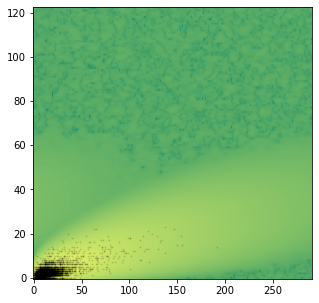

In [272]:
fig1,ax1=plt.subplots(figsize=(5,5))
ax1.imshow(np.log(Pss_cir.T),aspect='auto',cmap='summer')
ax1.invert_yaxis()
ax1.scatter(d_N,d_M,1,'k',alpha=0.1)

/tmp/ipykernel_3671016/1534031294.py:2: RuntimeWarning: divide by zero encountered in log
  ax1.imshow(np.log(Pss_gou.T),aspect='auto',cmap='summer')


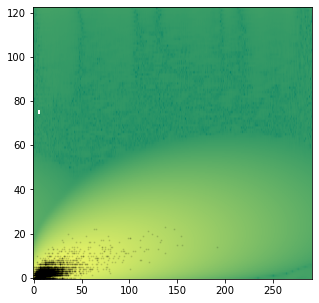

In [273]:
fig1,ax1=plt.subplots(figsize=(5,5))
ax1.imshow(np.log(Pss_gou.T),aspect='auto',cmap='summer')
ax1.invert_yaxis()
ax1.scatter(d_N,d_M,1,'k',alpha=0.1)

0.7323469387755102 0.995
0.7245487482792696 0.9949999999996137
0.8535714285714285 0.995
0.85360551494869 0.9949999999991096
0.1060204081632653 0.8333673469387755
0.44762090413030337 0.44762091051556696


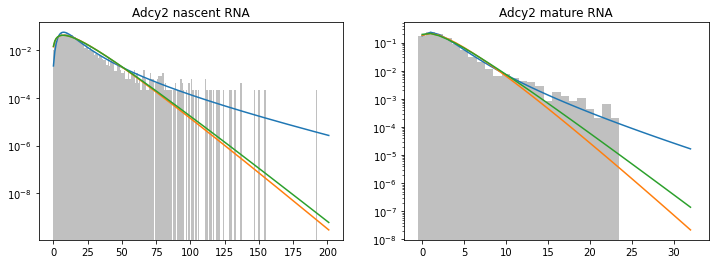

In [275]:
plot_hist(data, g_gou[0], ax=None,log=True)

In [247]:
C=scipy.special.logsumexp(logL_cir.flatten(),b=1/np.prod(logL_cir.shape))

In [263]:
np.exp(logL_cir-C).max()/2500

0.5553079090090302

In [255]:
scipy.special.logsumexp(logL_cir.flatten()-C,b=1/np.prod(logL_cir.shape))

-3.8813396940895473e-13

In [253]:
1/np.prod(logL_cir.shape)

0.0004

In [267]:
num_x, num_y = np.shape(logL)
epsilon = 0.005

K_avg = 1
beta = K_avg/d_N.mean()
gamma = K_avg/d_M.mean()
mx = [np.max(d_N)+100,np.max(d_M)+100]


logL_gou=np.loadtxt(resultdir+"logL_"+sample+"_"+gene+"_GOU.txt")
num_x, num_y = np.shape(logL_gou)
x_min, x_max = epsilon, 1-epsilon
y_min, y_max = epsilon, 1-epsilon
X, Y = np.linspace(x_min, x_max, num_x), np.linspace(y_min, y_max, num_y)
i,j=np.unravel_index(np.argmax(logL_gou),shape=(num_x, num_y))
x = X[i]
y = Y[j]
a, kappa, theta = convert_xy_to_params(x, y, beta, gamma, K_avg) 
params = [beta, gamma, a, kappa, theta]
Pss_gou = get_GOU_2sp(mx, params)

logL_cir=np.loadtxt(resultdir+"logL_"+sample+"_"+gene+"_CIR.txt")
num_x, num_y = np.shape(logL_cir)
x_min, x_max = epsilon, 1-epsilon
y_min, y_max = epsilon, 1-epsilon
X, Y = np.linspace(x_min, x_max, num_x), np.linspace(y_min, y_max, num_y)
i,j=np.unravel_index(np.argmax(logL_cir),shape=(num_x, num_y))
x = X[i]
y = Y[j]
a, kappa, theta = convert_xy_to_params(x, y, beta, gamma, K_avg) 
params = [beta, gamma, a, kappa, theta]
Pss_cir = get_CIR_2sp(mx, params)


In [268]:
np.log(Pss_gou[d_N,d_M]).sum()

-26682.344596372597

In [269]:
logL_gou[i,j]

-26832.998176431734

In [270]:
np.log(Pss_cir[d_N,d_M]).sum()

-26514.289428757384

In [271]:
logL_cir[i,j]

-26509.732236816497

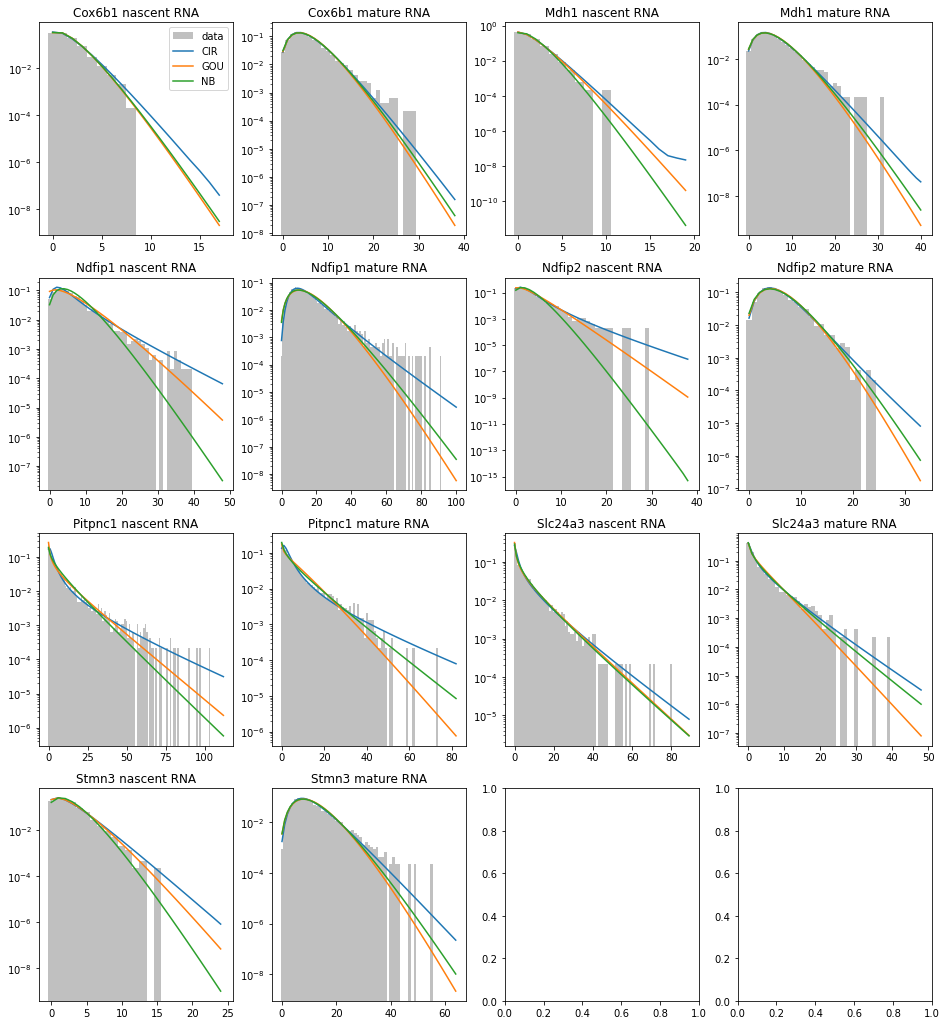

In [69]:
g_ = g_cir
fig, axs = plt.subplots(len(g_)//2+1,4,figsize=(16,4*len(g_)//2+4))

for k,gene in enumerate(g_):
    
    i = np.where(gene_names==gene)[0][0]
    d_M = S[i].astype(int)
    d_N = U[i].astype(int)
    data = [d_N, d_M]
    plot_hist(data, gene, ax=axs[k//2,2*(k%2):2*(k%2)+2])
    if k==0:
        axs[k//2,2*(k%2)].legend()
    

In [70]:
# axs[k//2,2*(k%2):2*(k%2)+2]

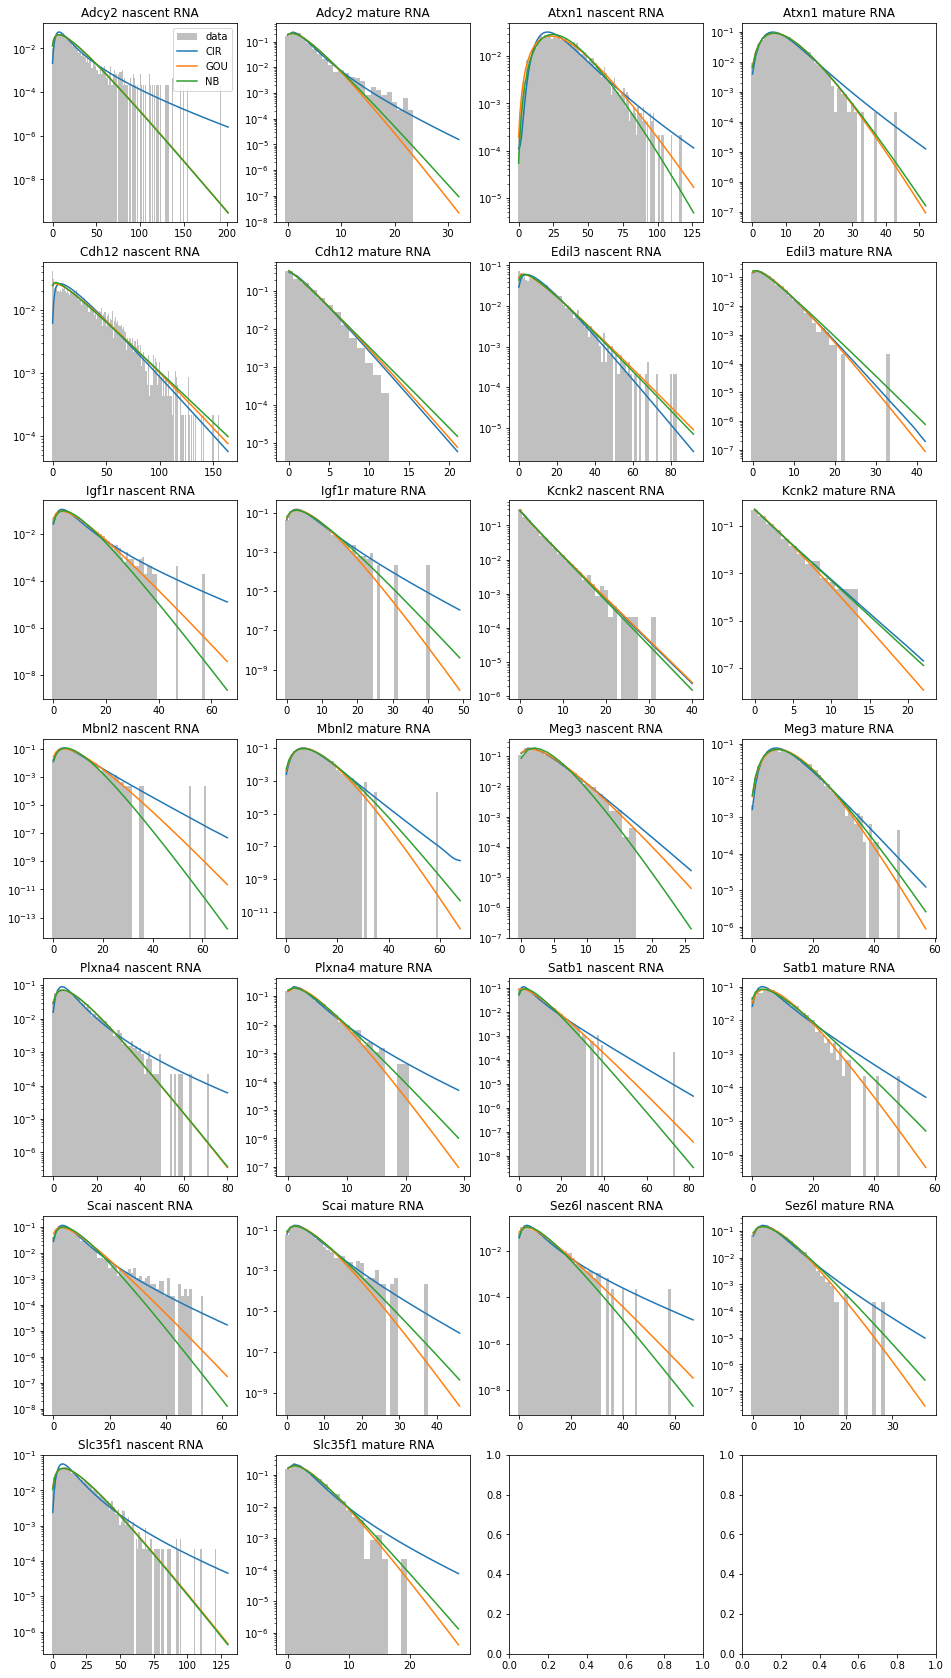

In [71]:
g_ = g_gou
fig, axs = plt.subplots(len(g_)//2+1,4,figsize=(16,4*len(g_)//2+4))

for k,gene in enumerate(g_):
    i = np.where(gene_names==gene)[0][0]
    d_M = S[i].astype(int)
    d_N = U[i].astype(int)
    data = [d_N, d_M]
    plot_hist(data, gene, ax=axs[k//2,2*(k%2):2*(k%2)+2])
    
    if k==0:
        axs[k//2,2*(k%2)].legend()
    

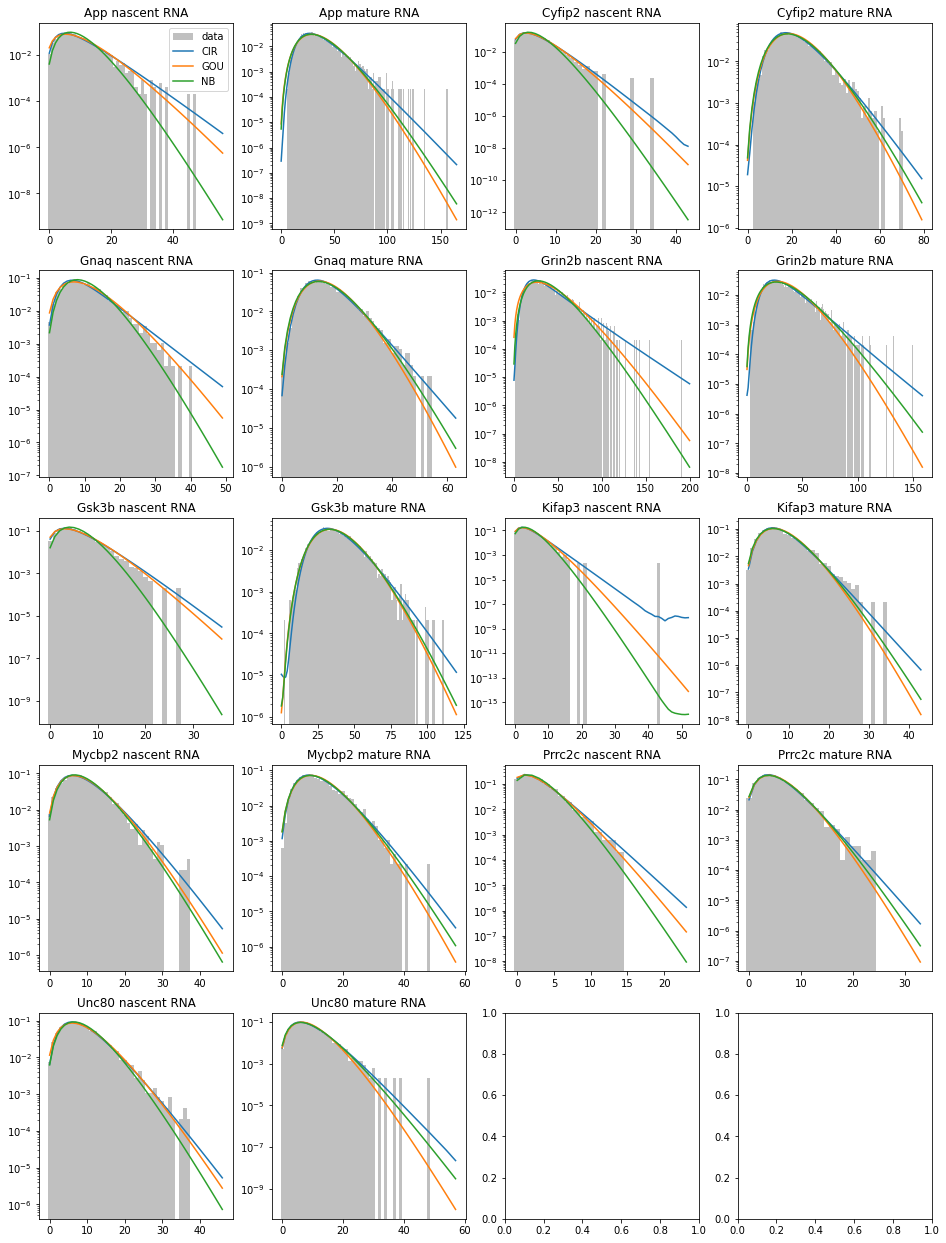

In [72]:
g_ = g_ext
fig, axs = plt.subplots(len(g_)//2+1,4,figsize=(16,4*len(g_)//2+4))

for k,gene in enumerate(g_):
    i = np.where(gene_names==gene)[0][0]
    d_M = S[i].astype(int)
    d_N = U[i].astype(int)
    data = [d_N, d_M]
    plot_hist(data, gene, ax=axs[k//2,2*(k%2):2*(k%2)+2])
    
    if k==0:
        axs[k//2,2*(k%2)].legend()
    

## BF plots

In [64]:
n_cells

NameError: name 'n_cells' is not defined

In [5]:
n_cells=[4674, 4394, 3335, 4820]

In [76]:

           
g_ext = ['App', 'Cyfip2', 'Gnaq', 'Grin2b', 'Gsk3b', 'Kifap3', 'Mycbp2',
       'Prrc2c', 'Unc80']
g_gou = ['Adcy2', 'Atxn1', 'Cdh12', 'Edil3', 'Igf1r', 'Kcnk2', 'Mbnl2',
       'Meg3', 'Plxna4', 'Satb1', 'Scai', 'Sez6l', 'Slc35f1']
g_cir = ['Cox6b1', 'Mdh1', 'Ndfip1', 'Ndfip2', 'Pitpnc1', 'Slc24a3',
       'Stmn3']
genes =  g_ext + g_gou + g_cir

In [77]:
len(g_ext)

9

In [78]:
len(g_cir)

7

In [79]:
len(genes)

29

In [80]:
n_genes = len(genes)
n_samples = len(samples)

In [81]:
import scipy
from scipy import special

These log-BFs still seem very inflated. It would be nice to check that the computation is correct.

In [102]:
BF = np.empty((n_samples,n_genes))
BF[:] = np.nan

# p_gou = 
for j in range(n_samples):
    for i in range(n_genes):
        logL_GOU = np.loadtxt('loom/grid_results/gg220626_res/logL_'+samples[j]+'_'+genes[i]+'_GOU.txt')
        logL_CIR = np.loadtxt('loom/grid_results/gg220626_res/logL_'+samples[j]+'_'+genes[i]+'_CIR.txt')
        # BF[j,i] = (scipy.special.logsumexp(logL_CIR,b=1/n_cells[j]) - scipy.special.logsumexp(logL_GOU,b=1/n_cells[j]))/np.log(10)
        w_ = np.asarray([0.5,0.5])/np.prod(logL_GOU.shape)
        BF[j,i] = (scipy.special.logsumexp(logL_CIR,b=w_[0]) - scipy.special.logsumexp(logL_GOU,b=w_[1]))/np.log(10)
        # c=np.max(logL_GOU)
        # d=np.max(logL_CIR)
        # llh_GOU = np.exp(logL_GOU-c)
        # llh_CIR = np.exp(logL_CIR-d)
        # lml_GOU = c+np.log(np.mean(llh_GOU))
        # lml_CIR = d+np.log(np.mean(llh_CIR))
        # BF[j,i] = (lml_CIR-lml_GOU)/np.log(10)

In [103]:
BF

array([[ 6.15719924e+01,  8.93645557e+00,  5.59528717e+00,
         3.49001257e+01,  2.90122901e+00,  1.95165544e+01,
         1.01137345e+01,  4.86736986e+00,  6.77007746e+00,
         7.77538850e+01, -7.50126490e+01, -1.18100224e+02,
        -2.07099819e+02, -8.13357997e+00, -4.18114814e+01,
         1.18984100e+01, -1.01702600e+01, -3.59160288e+01,
        -1.65612774e+02,  8.08143570e+01, -3.16007938e+01,
        -8.09979757e+01,  8.64929555e+00,  1.21729879e+01,
         1.49490395e+02,  2.19894586e+01,  6.22691915e+01,
        -1.19396995e+02,  3.74875464e+01],
       [ 4.01357732e+01,  6.75814916e+00,  7.03485631e-02,
         5.82661536e+01, -8.52496491e+00,  1.95185551e+01,
         2.12687621e+01,  1.63935368e+01,  2.84781975e-01,
        -3.80491057e+01, -1.04376696e+02, -1.65960604e+02,
        -2.05240347e+02, -5.02467171e+01, -1.07639836e+02,
        -5.95296765e+00, -2.23669545e-01, -6.06310946e+01,
        -1.51155646e+02, -3.56642647e+00, -7.36565407e+01,
        -9.37

Text(0.5, 0, 'Bayes factor: (+) CIR, $(-) \\ \\Gamma$-OU)')

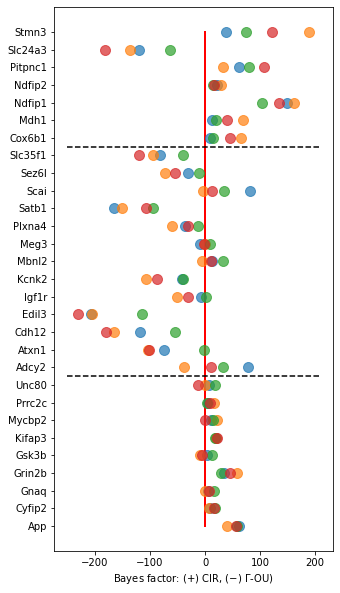

In [104]:
plt.figure(figsize=(5,10))

plt.plot([0,0],[0,28],'r-',linewidth=2)
plt.plot(BF.T,range(len(genes)),'.',markersize=20,alpha=0.7)
plt.yticks(ticks=range(len(genes)),labels=genes)

xl = plt.gca().get_xlim()
plt.plot(xl,[(len(g_ext)-0.5)]*2,'k--')
plt.plot(xl,[(len(g_ext)+len(g_gou)-0.5)]*2,'k--')
plt.xlabel(r'Bayes factor: (+) CIR, $(-) \ \Gamma$-OU)')

Text(0.5, 0, 'Bayes factor: (+) CIR, $(-) \\ \\Gamma$-OU)')

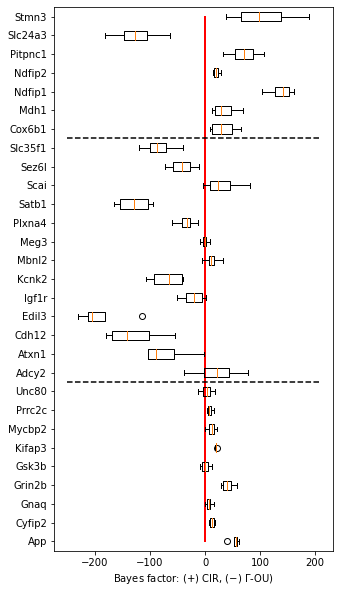

In [105]:
plt.figure(figsize=(5,10))

plt.plot([0,0],[0,28],'r-',linewidth=2)
plt.boxplot(BF,positions=range(len(genes)),vert=False)
plt.yticks(ticks=range(len(genes)),labels=genes)

plt.plot(xl,[(len(g_ext)-0.5)]*2,'k--')
plt.plot(xl,[(len(g_ext)+len(g_gou)-0.5)]*2,'k--')
plt.xlabel(r'Bayes factor: (+) CIR, $(-) \ \Gamma$-OU)')

In [99]:
import pickle
import theano.tensor as tt

import pymc3 as pm
# This class is necessary for interfacing with PymC3.

class LogLike(tt.Op):
    
    itypes = [tt.dvector] # expects a vector of parameter values when called
    otypes = [tt.dscalar] # outputs a single scalar value (the log likelihood)
    
    def __init__(self, mx, data, likelihood):
        
        # add inputs as class attributes
        self.mx = mx
        self.data = data
        self.likelihood = likelihood
        
    def perform(self, node, inputs, outputs):
        
        phi, = inputs # this contains parmeters
        logl = self.likelihood(phi, self.mx, self.data) # calls the log-likelihood function
        outputs[0][0] = np.array(logl) # output the log-likelihood


finished_genes = ['Scai','Cox6b1','Mdh1','Ndfip1', 'Ndfip2', 'Pitpnc1' 'Slc24a3','Stmn3','Igf1r','Adcy2','Atxn1']


n_samples,n_genes = len(samples),len(genes)
BF = np.empty((n_samples,n_genes))
BF[:] = np.nan
for j,sample in enumerate(samples):
    for i,gene in enumerate(genes):
        if gene in finished_genes:
            with open('loom/smc_results/four/'+sample+"_"+gene+'_GOU_trace.pickle', 'rb') as f:
                trace_GOU = pickle.load(f)
            with open('loom/smc_results/four/'+sample+"_"+gene+'_CIR_trace.pickle', 'rb') as f:
                trace_CIR = pickle.load(f)
            BF[j,i]= (trace_CIR.report.log_marginal_likelihood - trace_GOU.report.log_marginal_likelihood)/np.log(10)


ModuleNotFoundError: No module named 'cachetools.lru'

In [100]:
with open('loom/smc_results/four/'+sample+"_"+gene+'_GOU_trace.pickle', 'rb') as f:
    trace_GOU = pickle.load(f)

ModuleNotFoundError: No module named 'cachetools.lru'